In [53]:
import torch
import pandas as pd
import time
import re

In [54]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [55]:
oneg = pd.read_csv('../onegin.txt', sep='\n', header=None)

In [56]:
# читаем стихи
max_len = 0
phrases = []
for ind in range(len(oneg)):
    line = oneg[0][ind]
    line = line.lower()
    if re.search(r'\t', line):
        # удалить ^\t\t
        line = re.sub(r'\t\t', '', line)
        # удалить …………
        line = re.sub(r'…', '', line)
        # удалить все после [d]
        line = re.sub(r'\[\d*\].*$', '', line)
        # удалить все в квадратных скобках
        line = re.sub(r'\[.*\]', '', line)
        # удалить все анлгийские буквы
        line = re.sub(r'[abcdefghijklmnopqrstuvwxyz]', '', line)
        # заменить \xa0 на пробел
        line = re.sub(r'\xa0', ' ', line)
        # удалить ведущие и ведомые пробелы - не работает
        line = re.sub(r'^ *', '', line)
        line = re.sub(r' *$', '', line)
        # удалить знаки препинания
        line = re.sub(r'[\,\.\;\:\-\(\)\!\<\>\'\«\»\—/?\–\’\–\—]', '', line)
        # заменить двойной пробел на пробел
        line = re.sub(r'  ', ' ', line)
        
        line = line.strip()

        if len(line) > 0:
            phrases.append(line)
            line_len = len(line)
            if line_len > max_len:
                max_len = line_len

In [57]:
max_len

34

In [80]:
text = ' '.join(phrases)
text = re.sub(r'  ', ' ', text)  # убрать двойные пробелы
ALL_WORDS = set(text.strip().split(' '))
len(ALL_WORDS)

3142

In [81]:
from collections import Counter

In [82]:
c = Counter(text.split(' '))
c.most_common(10)

[('и', 305),
 ('в', 142),
 ('не', 100),
 ('он', 91),
 ('я', 61),
 ('на', 56),
 ('как', 55),
 ('но', 50),
 ('с', 47),
 ('что', 39)]

In [83]:
WORDS_COUNT = 3000
ALL_WORDS = set([w for w, _ in c.most_common(WORDS_COUNT)])
INDEX_TO_WORD = ['<pad>', '<miss>'] + list(ALL_WORDS)
len(INDEX_TO_WORD)

3002

In [84]:
WORD_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_WORD)}
INDEX_TO_WORD[:10]

['<pad>',
 '<miss>',
 'улицы',
 'сохранит',
 'возвращённый',
 'потери',
 'соседа',
 'всех',
 'зритель',
 'вольности']

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([  6.,   0.,   0.,   0.,   0.,   0.,   0.,  36.,   0.,   0.,   0.,
          0.,   0.,   0., 352.,   0.,   0.,   0.,   0.,   0.,   0., 561.,
          0.,   0.,   0.,   0.,   0.,   0., 342.,   0.,   0.,   0.,   0.,
          0.,   0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,  26.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.  , 1.14, 1.28, 1.42, 1.56, 1.7 , 1.84, 1.98, 2.12, 2.26, 2.4 ,
        2.54, 2.68, 2.82, 2.96, 3.1 , 3.24, 3.38, 3.52, 3.66, 3.8 , 3.94,
        4.08, 4.22, 4.36, 4.5 , 4.64, 4.78, 4.92, 5.06, 5.2 , 5.34, 5.48,
        5.62, 5.76, 5.9 , 6.04, 6.18, 6.32, 6.46, 6.6 , 6.74, 6.88, 7.02,
        7.16, 7.3 , 7.44, 7.58, 7.72, 7.86, 8.  ]),
 <a list of 50 Patch objects>)

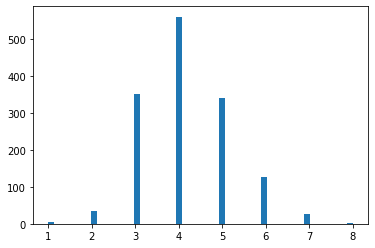

In [87]:
# распреление длины слов в строке
plt.hist([len(s.split(' ')) for s in phrases], bins=50)

In [98]:
MAX_LEN = 8

In [99]:
X = torch.zeros((len(phrases), MAX_LEN), dtype=int).to(dev)

In [100]:
# готовим матрицу - строка - фраза, столбец - индекс слова в этой позиции
for i in range(len(phrases)):
    for j, w in enumerate(phrases[i].split(' ')):
        if j >= MAX_LEN:
            break
        X[i, j] = WORD_TO_INDEX.get(w, WORD_TO_INDEX['<miss>'])

In [101]:
X[0:1]

tensor([[2651, 1648,  702, 1921,    0,    0,    0,    0]], device='cuda:0')

In [102]:
class Network(torch.nn.Module):

    def __init__(self, dev):
        super(Network, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding(len(INDEX_TO_WORD), 200).to(self.dev)
        self.gru = torch.nn.RNN(200, 128, num_layers = 2, nonlinearity = 'relu', batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

    def forward_state(self, sentences, state):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [152]:
class NetworkGRU(torch.nn.Module):

    def __init__(self, dev):
        super(NetworkGRU, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding(len(INDEX_TO_WORD), 200).to(self.dev)
        self.gru = torch.nn.GRU(200, 128, num_layers = 1, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

    def forward_state(self, sentences, state):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [153]:
class NetworkLSTM(torch.nn.Module):

    def __init__(self, dev):
        super(NetworkLSTM, self).__init__()
        self.dev = dev
        self.word_embeddings = torch.nn.Embedding(len(INDEX_TO_WORD), 200).to(self.dev)
        self.gru = torch.nn.LSTM(200, 128, num_layers = 1, batch_first=True).to(self.dev)
        self.hidden2tag = torch.nn.Linear(128, len(INDEX_TO_WORD)).to(self.dev)

    def forward(self, sentences):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

    def forward_state(self, sentences, state):
        embeds = self.word_embeddings(sentences)
        gru_out, state = self.gru(embeds, state)
        tag_space = self.hidden2tag(gru_out.reshape(-1, 128))
        return tag_space.reshape(sentences.shape[0], sentences.shape[1], -1), state

In [154]:
model = Network(dev)
model.forward(X[0:1])[0].shape

torch.Size([1, 8, 3002])

In [155]:
modelGRU = NetworkGRU(dev)
modelGRU.forward(X[0:1])[0].shape

torch.Size([1, 8, 3002])

In [156]:
modelLSTM = NetworkLSTM(dev)
modelLSTM.forward(X[0:1])[0].shape

torch.Size([1, 8, 3002])

In [157]:
def generate_sentence(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        #X = torch.Tensor([[WORD_TO_INDEX[sentence[i]]]]).type(torch.long)
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        #get(w, WORD_TO_INDEX['<miss>']
        X = X.to(dev)
        if i == 0:
            result, state = model.forward(X)
        else:
            result, state = model.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [158]:
def generate_sentence_GRU(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        X = X.to(dev)
        if i == 0:
            result, state = modelGRU.forward(X)
        else:
            result, state = modelGRU.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])

    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)        

In [159]:
def generate_sentence_LSTM(line):
    sentence = line.split(' ')
    #sentence = ['к', 'а', 'к', ' ', 'р', 'а', 'н', 'о',' ']
    state = None
    for i in range(MAX_LEN):
        X = torch.Tensor([[WORD_TO_INDEX.get(sentence[i],WORD_TO_INDEX['<miss>'])]]).type(torch.long)
        X = X.to(dev)
        if i == 0:
            result, state = modelLSTM.forward(X)
        else:
            result, state = modelLSTM.forward_state(X, state)
        prediction = result[0, -1, :]
        index_of_prediction = prediction.argmax()
        if i >= len(sentence) - 1:
            if index_of_prediction == 0:
                break
        sentence.append(INDEX_TO_WORD[index_of_prediction])
        
    line = ' '.join(sentence)
    line = re.sub(r'none.*$', '', line)
    print(line)

In [160]:
generate_sentence('как рано')

как рано двор озлоблен сторон умен шёпот воспоминать занавес прими


In [161]:
generate_sentence_GRU('как рано')

как рано былом безмерно бред ими венчался всего озарит сумрачной


In [162]:
generate_sentence_LSTM('как рано')

как рано снег томный боготворил моде поспеть прадедов инвалид снег


In [169]:
lrate = .1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrate)

criterionGRU = torch.nn.CrossEntropyLoss()
optimizerGRU = torch.optim.SGD(modelGRU.parameters(), lr=lrate)

criterionLSTM = torch.nn.CrossEntropyLoss()
optimizerLSTM = torch.optim.SGD(modelLSTM.parameters(), lr=lrate)

In [188]:
count = 0

for ep in range(1000):
    
    # RNN section
    start = time.time()
    train_loss = 0.
    train_passed = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizer.zero_grad()
        answers, _ = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1
    end = time.time()
        
    # GRU section
    startGRU = time.time()
    train_lossGRU = 0.
    train_passedGRU = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizerGRU.zero_grad()
        answers, _ = modelGRU.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterionGRU(answers, Y_batch)
        train_lossGRU += loss.item()

        loss.backward()
        optimizerGRU.step()
        train_passedGRU += 1
    endGRU = time.time()
    
    # LSTM section
    startLSTM = time.time()
    train_lossLSTM = 0.
    train_passedLSTM = 0
    
    for i in range(int(len(X) / 100)):
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1]
        Y_batch = batch[:, 1:].flatten()

        optimizerLSTM.zero_grad()
        answers, _ = modelLSTM.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_WORD))
        loss = criterionLSTM(answers, Y_batch)
        train_lossLSTM += loss.item()

        loss.backward()
        optimizerLSTM.step()
        train_passedLSTM += 1
    endLSTM = time.time()
    
    count += 1
    if count == 20:
        count = 0
        trloss = train_loss / train_passed
        trlossGRU = train_lossGRU / train_passedGRU
        trlossLSTM = train_lossLSTM / train_passedLSTM
        print("Epoch {}. Time,GRU,LSTM: {:.3f},{:.3f},{:.3f}, Train loss,GRU,LSTM: {:.3f},{:.3f},{:.3f}, delta RGU,LSTM:{:.3f},{:.3f}".format(ep, end - start, endGRU - startGRU, endLSTM - startLSTM, trloss, trlossGRU,trlossLSTM, trloss - trlossGRU,trloss - trlossLSTM))
        generate_sentence('как рано')
        generate_sentence_GRU('как рано')        
        generate_sentence_LSTM('как рано')        

Epoch 19. Time,GRU,LSTM: 0.100,0.080,0.080, Train loss,GRU,LSTM: 0.265,0.315,0.375, delta RGU,LSTM:-0.050,-0.110
как рано он мог он <pad> то <pad> <pad> <pad>
как рано он мог знал оценить <pad> <pad> <pad> <pad>
как рано он мог лицемерить лицемерить <pad> <pad> <pad> <pad>
Epoch 39. Time,GRU,LSTM: 0.100,0.080,0.080, Train loss,GRU,LSTM: 0.265,0.314,0.372, delta RGU,LSTM:-0.049,-0.107
как рано он мог он <pad> то <pad> <pad> <pad>
как рано он мог знал оценить <pad> <pad> <pad> <pad>
как рано он мог лицемерить лицемерить <pad> <pad> <pad> <pad>
Epoch 59. Time,GRU,LSTM: 0.095,0.080,0.085, Train loss,GRU,LSTM: 0.265,0.312,0.369, delta RGU,LSTM:-0.048,-0.104
как рано он мог он <pad> то <pad> <pad> <pad>
как рано он мог знал оценить <pad> <pad> <pad> <pad>
как рано он мог лицемерить лицемерить <pad> <pad> <pad> <pad>
Epoch 79. Time,GRU,LSTM: 0.100,0.080,0.080, Train loss,GRU,LSTM: 0.265,0.311,0.366, delta RGU,LSTM:-0.047,-0.101
как рано он мог он <pad> то <pad> <pad> <pad>
как рано он мог зна

In [189]:
def generate_sentence2(line):
    generate_sentence(line)
    generate_sentence_GRU(line)
    generate_sentence_LSTM(line)

In [190]:
generate_sentence2('как рано')

как рано он мог он <pad> то <pad> <pad> <pad>
как рано он мог знал оценить <pad> <pad> <pad> <pad>
как рано он мог лицемерить лицемерить <pad> <pad> <pad> <pad>


In [191]:
generate_sentence2('привет чувак')

привет чувак <miss> <miss> она <pad> <pad> <pad> <pad> <pad>
привет чувак <miss> <miss> <pad> <pad> <pad> <pad> <pad> <pad>
привет чувак <miss> <miss> <pad> <pad> <pad> <pad> <pad> <pad>


In [192]:
generate_sentence2('а')

а кстати <miss> <miss>
а кстати <miss> <miss>
а уж онегин вышел вон


In [193]:
generate_sentence2('карета')

карета <miss> <miss> она
карета <miss> <miss>
карета <miss> <miss>


In [203]:
generate_sentence2('и')

и нам досталось от него
и к размышлению влекло
и нам он сердце шевелит


In [195]:
generate_sentence2('так думал молодой')

так думал молодой я молодой повеса привык <pad> <pad> <pad> <pad>
так думал молодой наше молодой повеса <pad> <pad> <pad> <pad> <pad>
так думал молодой не молодой повеса повеса <pad> <pad> <pad> <pad>


In [196]:
generate_sentence2('с новым годом')

с новым годом душою охтинка <pad> она нет <pad> <pad> <pad>
с новым годом ним друзья с <miss> <pad> <pad> <pad> <pad>
с новым годом ним сидеть водой <pad> <pad> <pad> <pad> <pad>


In [197]:
generate_sentence2('дед')

дед <miss> <miss> она
дед <miss> <miss>
дед <miss> <miss>


In [198]:
generate_sentence2('баба')

баба <miss> <miss> она
баба <miss> <miss>
баба <miss> <miss>


In [199]:
generate_sentence2('как')

как он умел казаться новым
как он умел забыть себя
как он умел забыть себя


In [200]:
generate_sentence2('вздох')

вздох он очень детстве
вздох он пеплу посвятил
вздох он в руках


In [201]:
generate_sentence2('латынь')

латынь из моды вышла ныне
латынь из моды вышла ныне
латынь из моды вышла ныне


In [202]:
generate_sentence2('говорил')

говорил об них
говорил дождусь ли дня
говорил дождусь


In [204]:
generate_sentence2('что')

что он опаснейший чудак
что он опаснейший чудак
что он умен и очень мил


In [207]:
generate_sentence2('то')

то говорливой то немой
то есть умел судить о том
то стан совьёт то разовьёт


In [208]:
generate_sentence2('как')

как он умел казаться новым
как он умел забыть себя
как он умел забыть себя


In [209]:
generate_sentence2('свой')

свой век блестящий и мятежный
свой век блестящий и мятежный
свой век блестящий и мятежный


In [210]:
generate_sentence2('молдавии')

молдавии и гвардии странный
молдавии в глуши степей
молдавии в глуши степей


In [211]:
generate_sentence2('была')

была заманчивой загадкой
была наука страсти нежной
была наука страсти нежной
